Dataset shape: (31853, 40)


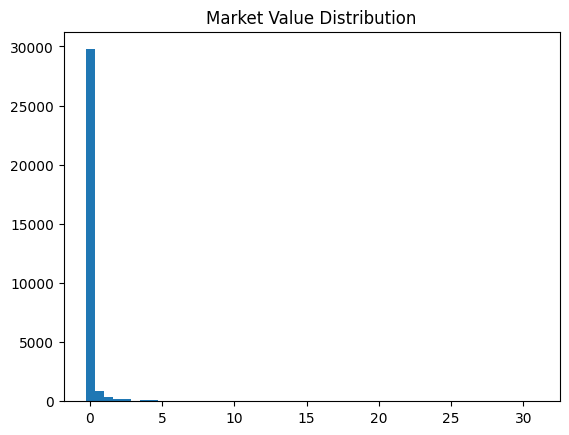

RF MSE: 0.0008947339848016303
RF R2 Score: 0.9991607102085085
Epoch 1/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 0.0248 - mae: 0.0471 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 2/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0013 - mae: 0.0220 - val_loss: 0.0014 - val_mae: 0.0271
Epoch 3/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.0039 - mae: 0.0275 - val_loss: 0.0016 - val_mae: 0.0266
Epoch 4/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 5.5295e-04 - mae: 0.0149 - val_loss: 2.5272e-04 - val_mae: 0.0112
Epoch 5/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 2.7287e-04 - mae: 0.0107 - val_loss: 2.4661e-04 - val_mae: 0.0111
Epoch 6/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 9.3979e-04 - mae: 0.0149 - val_loss: 0.0043 - val_mae: 0.0531
Epoch 7/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 9.7452e-04 - mae: 0.0158 - val_loss: 2.3930e-04 - val_mae: 0.0107
Epoch 8/20
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 8.0298e-

In [1]:
# ==============================
# TransferIQ EDA & Model Notebook
# ==============================

# ------------------------------
# 1. Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate

# ------------------------------
# 2. Load Dataset
# ------------------------------
df = pd.read_csv("/Users/veerababu/Downloads/cleaned/master_list_final_features.csv")
print("Dataset shape:", df.shape)
df.head()

# ------------------------------
# 3. Exploratory Data Analysis
# ------------------------------
# Check for missing values
df.isna().sum()

# Basic statistics
df.describe()

# Example: Distribution of target
import matplotlib.pyplot as plt
plt.hist(df['market_value_in_eur'], bins=50)
plt.title("Market Value Distribution")
plt.show()

# ------------------------------
# 4. Feature Engineering & Preprocessing
# ------------------------------
numeric_features = ['age', 'experience_years', 'height_in_cm',
                    'total_injuries', 'total_days_missed',
                    'contract_years_remaining', 'market_value_in_eur']

# Fill missing numeric values
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

cat_features = ['current_club_name', 'sub_position']
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Target variable
y = df['market_value_in_eur'].astype(float).values

# Split numeric & categorical features
X_num = df[numeric_features].values
X_cat = df[cat_features].values

X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

# ------------------------------
# 5. Random Forest Model
# ------------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_num, y_train)
rf_preds = rf_model.predict(X_test_num)

print("RF MSE:", mean_squared_error(y_test, rf_preds))
print("RF R2 Score:", r2_score(y_test, rf_preds))

# ------------------------------
# 6. Neural Network Model with Embeddings
# ------------------------------
inputs = []
embeddings = []

for i, col in enumerate(cat_features):
    vocab_size = df[col].nunique() + 1
    embed_dim = min(50, vocab_size // 2)
    input_i = Input(shape=(1,))
    embedding_i = Embedding(vocab_size, embed_dim)(input_i)
    embedding_i = Flatten()(embedding_i)
    inputs.append(input_i)
    embeddings.append(embedding_i)

# Numeric input
num_input = Input(shape=(X_train_num.shape[1],))
inputs.append(num_input)
embeddings.append(num_input)

# Concatenate and build model
x = Concatenate()(embeddings)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(1)(x)

nn_model = Model(inputs=inputs, outputs=output)
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = nn_model.fit(
    [X_train_cat[:, i] for i in range(X_train_cat.shape[1])] + [X_train_num],
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

# Evaluate
loss, mae = nn_model.evaluate(
    [X_test_cat[:, i] for i in range(X_test_cat.shape[1])] + [X_test_num], y_test
)
print("NN Test MAE:", mae)

# ------------------------------
# 7. Save Models & Predictions
# ------------------------------
import joblib
rf_path = "/Users/veerababu/Downloads/cleaned/rf_model.pkl"
nn_path = "/Users/veerababu/Downloads/cleaned/nn_model.keras"
pred_path = "/Users/veerababu/Downloads/cleaned/predictions.csv"

joblib.dump(rf_model, rf_path)
nn_model.save(nn_path)

preds_df = pd.DataFrame({
    'RF_Predictions': rf_preds,
    'NN_Predictions': nn_model.predict([X_test_cat[:, i] for i in range(X_test_cat.shape[1])] + [X_test_num]).flatten(),
    'Actual': y_test
})
preds_df.to_csv(pred_path, index=False)

print("Models and predictions saved successfully!")
